## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

Created for Coursera guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/learn/tweet-emotion-tensorflow)

---

## Task 1: Introduction


## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
import random
from typing import Dict, List, Tuple

import tensorflow as tf
import numpy as np

from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline

2023-01-18 18:17:10.649986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 18:17:12.562475: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-18 18:17:12.562692: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-18 18:17:12.562704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
def show_history(h: Dict[str, np.ndarray]) -> None:
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, classes: List[str]) -> None:
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print(f'Using TensorFlow version {tf.__version__}')

Using TensorFlow version 2.11.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

_HuggingFace is now providing a new version of the Emotion dataset with some adjustments that might differ from the guided project from Coursera._

In [3]:
dataset = load_dataset('emotion')

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/gustas/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)
100%|██████████| 3/3 [00:00<00:00, 874.72it/s]


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweets(data: Dataset) -> Tuple[List[str], List[int]]:
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [7]:
tweets, labels = get_tweets(train)

In [8]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [9]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

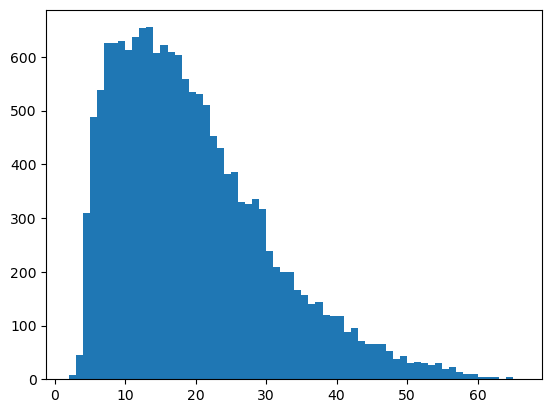

In [10]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [11]:
def get_sequences(tokenizer: Tokenizer, tweets: List[str]) -> np.ndarray:
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [12]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [13]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [14]:
classes = {'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}
print(classes)

{'joy', 'surprise', 'love', 'sadness', 'anger', 'fear'}


In [15]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [16]:
classes_to_index

{'joy': 0, 'surprise': 1, 'love': 2, 'sadness': 3, 'anger': 4, 'fear': 5}

In [17]:
index_to_classes

{0: 'joy', 1: 'surprise', 2: 'love', 3: 'sadness', 4: 'anger', 5: 'fear'}

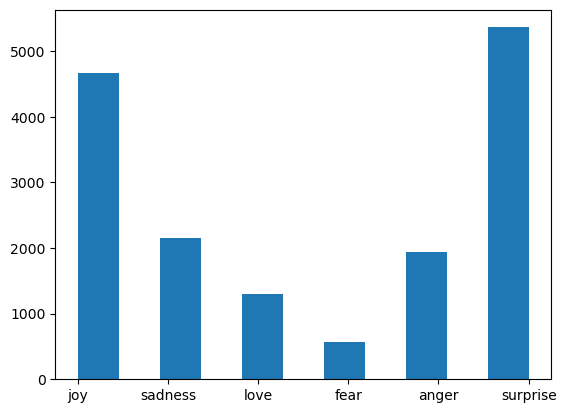

In [18]:
plt.hist(list(map(index_to_classes.get, labels)), bins=11)
plt.show()

In [19]:
# Instead of a lambda function proposed in the guided project, we just need to convert from a list to a numpy array
train_labels = np.array(labels)

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

2023-01-18 18:17:20.738825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-18 18:17:20.775636: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-01-18 18:17:20.775664: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-18 18:17:20.776322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [21]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = np.array(val_labels)

In [22]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [23]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 26s 44ms/step - loss: 1.3490 - accuracy: 0.4692 - val_loss: 1.0676 - val_accuracy: 0.5905
Epoch 2/20
500/500 [==============================] - 22s 44ms/step - loss: 0.8551 - accuracy: 0.6636 - val_loss: 0.7281 - val_accuracy: 0.7355
Epoch 3/20
500/500 [==============================] - 21s 43ms/step - loss: 0.4460 - accuracy: 0.8489 - val_loss: 0.4521 - val_accuracy: 0.8610
Epoch 4/20
500/500 [==============================] - 23s 45ms/step - loss: 0.2394 - accuracy: 0.9235 - val_loss: 0.4108 - val_accuracy: 0.8670
Epoch 5/20
500/500 [==============================] - 27s 53ms/step - loss: 0.1754 - accuracy: 0.9418 - val_loss: 0.4590 - val_accuracy: 0.8590
Epoch 6/20
500/500 [==============================] - 24s 47ms/step - loss: 0.1353 - accuracy: 0.9562 - val_loss: 0.4352 - val_accuracy: 0.8765
Epoch 7/20
500/500 [==============================] - 23s 45ms/step - loss: 0.1068 - accuracy: 0.9656 - val_loss: 0.3699 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

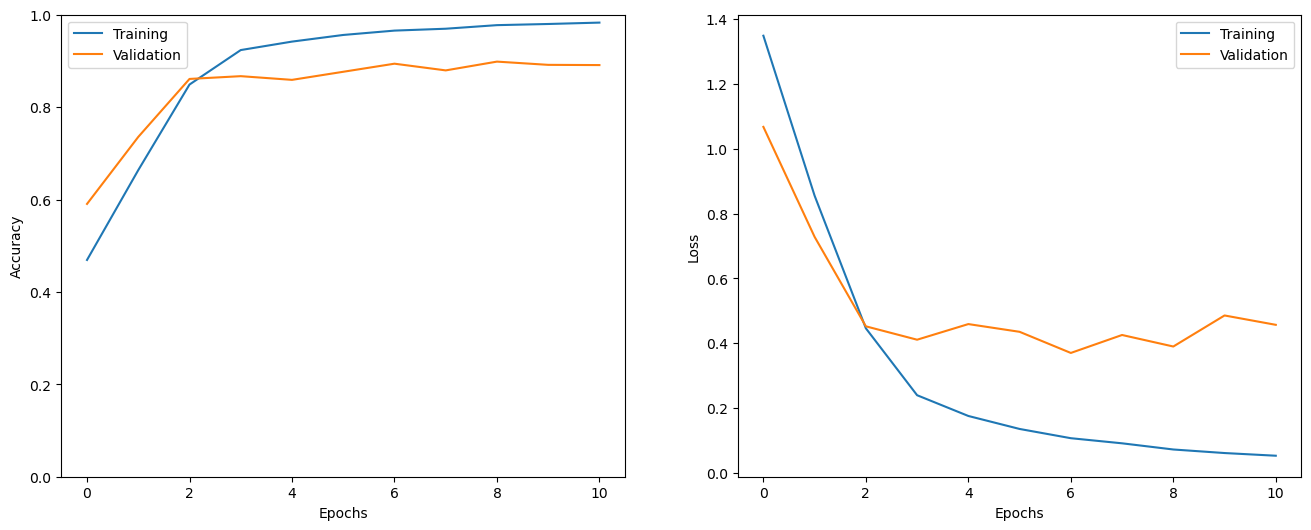

In [24]:
show_history(h)

In [25]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = np.array(test_labels)

In [26]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 1s 14ms/step - loss: 0.4528 - accuracy: 0.8865


In [27]:
i = random.randint(0, len(test_labels) - 1)

print(f'Sentence: {test_tweets[i]}')
print(f'Emotion: {index_to_classes[test_labels[i]]}')

p = np.argmax(model.predict(np.expand_dims(test_sequences[i], axis=0)), axis=-1)[0]

print(f'Predicted Emotion: {index_to_classes.get(p)}')

Sentence: i didn t feel talented at anything i was doing and eventually wasn t putting fully into it
Emotion: surprise
1/1 [==============================] - 1s 1s/step
Predicted Emotion: surprise


In [28]:
preds = np.argmax(model.predict(test_sequences), axis=-1)
preds.shape, test_labels.shape

63/63 [==============================] - 1s 16ms/step


((2000,), (2000,))

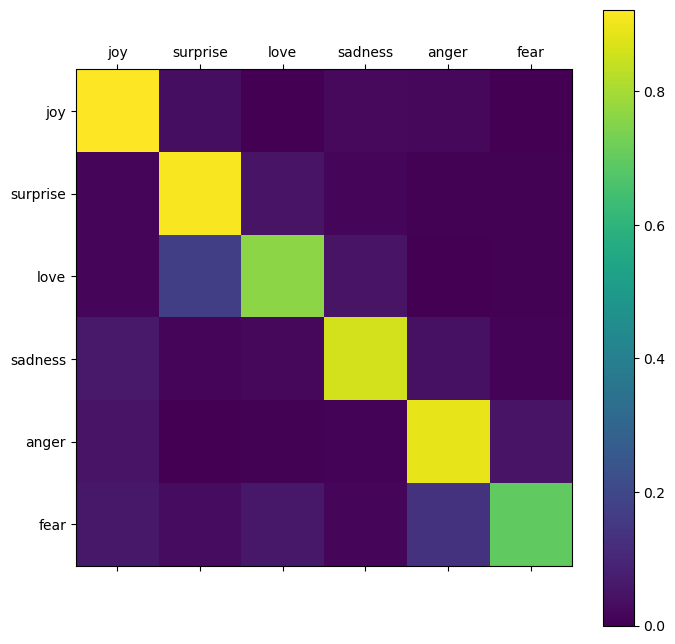

In [29]:
show_confusion_matrix(test_labels, preds, list(classes))